In [23]:
from casadi import *
import numpy as np
from enum import Enum
from copy import deepcopy
import matplotlib.pyplot as plt


In [24]:
class ShootingPlot:
    def __init__(self, t0, tf, NumberShootingNodes, DAE_info, NrEvaluationPoints=40):

        self.t0 = t0
        self.tf = tf
        self.NumberShootingNodes = NumberShootingNodes

        self.NrEvaluationPoints = NrEvaluationPoints

        intg, SizeOfx0, SizeOfp, I_plot = \
            DAE_info(t0, (tf-t0)/NumberShootingNodes, NrEvaluationPoints=NrEvaluationPoints)

        self.Sn, self.p, self.intg_exp = \
            BuildCasADiExpFromIntegrator(NumberShootingNodes, I_plot, SizeOfx0, SizeOfp, False)
        self.eval_intg_exp = Function('eval_intg_exp', [self.Sn, self.p], [self.intg_exp['xf']], ['x0', 'p'], ['out'])

        self.Sn_mapaccum, self.p_mapaccum, self.intg_exp_mapaccum = \
            BuildCasADiExpFromIntegrator(NumberShootingNodes, I_plot, SizeOfx0, SizeOfp, True)
        self.eval_intg_exp_mapaccum = \
            Function('eval_intg_exp_mapaccum',
                     [self.Sn_mapaccum, self.p_mapaccum], [self.intg_exp_mapaccum['xf']], ['x0', 'p'], ['out'])
    pass

    def Plot(self, x0, p, mapaccum=False):
        # https://stackoverflow.com/questions/13359951/is-there-a-list-of-line-styles-in-matplotlib
        linestyle = {0: '-', 1: '-.', 2: '--', 3: ':'}

        if mapaccum == False:
            res = self.eval_intg_exp(x0, p)
        else:
            res = self.eval_intg_exp_mapaccum(x0, p)


        #for dof in range(0, len(x0)):
        for dof in range(0, x0.size1()):
            indx_shoots = 0
            legend_ok=True
            for indx in np.arange(self.t0, self.tf, (self.tf-self.t0)/self.NumberShootingNodes):
                if legend_ok:
                    label=str(dof) + ' dof'
                else:
                    label=''
                res_x_dof = res[dof, :]
                shoots_x_dof = reshape(res_x_dof, self.NrEvaluationPoints, self.NumberShootingNodes)
                plt.plot(np.linspace(
                    indx, indx + (self.tf-self.t0)/self.NumberShootingNodes, self.NrEvaluationPoints),
                    shoots_x_dof[:, indx_shoots], label=label, linestyle=linestyle[dof % len(linestyle)])
                plt.axvline(x=indx, color='k', linestyle='-', linewidth=0.1)
                plt.axvline(x=indx+(self.tf-self.t0)/self.NumberShootingNodes, color='k', linestyle='-', linewidth=0.1)
                indx_shoots += 1
                legend_ok=False
        plt.legend()
        plt.show()
        pass


In [25]:
class OptSolver(Enum):
    nlp = 0
    qp = 1


In [26]:
def BuildCasADiExpFromIntegrator(NumberShootingNodes, intg, SizeOfx0, SizeOfp, mapaccum=False):
    p = MX.sym('p', SizeOfp);

    if mapaccum == False:
        #map(N,"thread",2)
        F = intg.map(NumberShootingNodes)
        Sn = MX.sym('Sn', SizeOfx0, NumberShootingNodes)
        intg_exp = F(x0=Sn, p=repmat(p, 1, NumberShootingNodes))
    else:
        F = intg.mapaccum(NumberShootingNodes)
        Sn = MX.sym('Sn', SizeOfx0)
        intg_exp = F(x0=Sn, p=repmat(p, 1, NumberShootingNodes))

    # return [symbolic input variables] and [symbolic integrator as expression]
    return Sn, p, intg_exp


In [27]:
def NLP(x0, p, eval_F1_exp, eval_F2_exp, GroundTruth_perturb, CasADi_norm, Ploting):
    norm_F1_exp = CasADi_norm(eval_F1_exp(x0, p)) @ CasADi_norm(eval_F1_exp(x0, p))
    eval_norm_F1_exp = Function('eval_norm_F1_exp', [x0, p], [norm_F1_exp], ['x0_perturb', 'p_perturb'], ['out'])

    nlp = {'x': vertcat(reshape(x0, x0.numel(), 1), p),
           'f': eval_norm_F1_exp(x0, p),
           'g': eval_F2_exp(x0, p)
           }
    SolverNLP = nlpsol('S', 'ipopt', nlp)

    print(SolverNLP)

    shape = GroundTruth_perturb['Sn'].shape
    initVal = GroundTruth_perturb
    # GroundTruth_perturb is used as a starting point!
    result = SolverNLP(
        x0=vertcat(
            reshape(GroundTruth_perturb['Sn'], GroundTruth_perturb['Sn'].numel(), 1),
            GroundTruth_perturb['p']),
        lbg=0,
        ubg=0
        # lbg=repmat(0, x0.numel()-GroundTruth_perturb['Sn'].size1()),
        # ubg=repmat(0, x0.numel()-GroundTruth_perturb['Sn'].size1())
    )
    print('\n');
    print("x0_found: ", result['x'][:2], "p_found: ", result['x'][-p.numel():])
    Ploting.Plot(reshape(result['x'][:x0.numel()], shape), result['x'][x0.numel():], False)
    print(initVal)
    print('\n')
    print(result['x'])
    print(GroundTruth)
    print("min:", result['f']);
    print('\n')
    pass


In [28]:
#precision_error=0.001
#precision_error=0.000001
#precision_error=0.00000001
def QP(x0, p, eval_F1_exp, eval_F2_exp, GroundTruth_perturb, CasADi_norm, Ploting, precision_error=0.000001, nrIteration=20):
    # jacobian_exp = jacobian(F1_exp, vertcat(x0, p))
    jacobian_F1_exp = jacobian(eval_F1_exp(x0, p), vertcat(reshape(x0, x0.numel(), 1), p))
    eval_jacobian_F1_exp = Function('eval_jacobian_exp', [x0, p], [jacobian_F1_exp], ['x0_perturb', 'p_perturb'],
                                    ['out'])

    DeltaX = MX.sym('DeltaX', x0.numel() + p.size1())

    inner_exp = eval_F1_exp(x0, p) + eval_jacobian_F1_exp(x0, p) @ DeltaX

    eval_inner_exp = Function('eval_inner_exp', [x0, p, DeltaX], [inner_exp], ['x0_perturb', 'p_perturb', 'DeltaX'],
                              ['out'])

    norm_GGN_exp = CasADi_norm(eval_inner_exp(x0, p, DeltaX)) @ CasADi_norm(eval_inner_exp(x0, p, DeltaX))

    # DeltaX must be DeltaX!
    eval_norm_GGN_exp = Function('eval_norm_GGN_exp', [x0, p, DeltaX], [norm_GGN_exp],
                                 ['x0_perturb', 'p_perturb', 'DeltaX'], ['out'])

    ##
    # eval F2(perturb)
    # compute J2()
    # evaluate F2 + J2 X DeltaX
    jacobian_F2_exp = jacobian(eval_F2_exp(x0, p), vertcat(reshape(x0, x0.numel(), 1), p))
    eval_jacobian_F2_exp = \
        Function('eval_jacobian_F2_exp', [x0, p], [jacobian_F2_exp], ['x0_perturb', 'p_perturb'], ['out'])
    F2_inner_exp = eval_F2_exp(x0, p) + eval_jacobian_F2_exp(x0, p) @ DeltaX
    eval_F2_inner_exp = Function('eval_F2_inner_exp', [x0, p, DeltaX], [F2_inner_exp],
                                 ['x0_perturb', 'p_perturb', 'DeltaX'], ['out'])
    ##

    sol = vertcat(
        reshape(GroundTruth_perturb['Sn'], GroundTruth_perturb['Sn'].numel(), 1),
        GroundTruth_perturb['p']
    )
    shape = GroundTruth_perturb['Sn'].shape

    for idx in range(0, nrIteration):
        # DeltaX must be DeltaX!!
        qp = {
            'x': DeltaX,
            'f': eval_norm_GGN_exp(reshape(sol[:x0.numel()], shape), sol[x0.numel():], DeltaX),
            'g': eval_F2_inner_exp(reshape(sol[:x0.numel()], shape), sol[x0.numel():], DeltaX)
        }
        SolverQP = qpsol('S', 'qpoases', qp)
        print(SolverQP)
        result = SolverQP(x0=sol, lbg=0, ubg=0)
        print(sol)
        Ploting.Plot(reshape(sol[:x0.numel()], shape), sol[x0.numel():], False)
        #sol = sol + 0.1 * result['x']
        sol = sol + result['x']
        Ploting.Plot(reshape(sol[:x0.numel()], shape), sol[x0.numel():], False)
        #sol = sol + result['x']
        print(sol)
        print("min:", result['f'])
        if (result['f'] <= precision_error):
            print("Solution found!")
            break;

    pass


In [29]:
# NumberShootingNodes >=1
def ParametricEstimation(DAE_info, GroundTruth, GroundTruth_perturb, Solver=OptSolver.nlp,
                         CasADi_norm=norm_2, t0=0, tf=10, NumberShootingNodes=8, TrueSolutionMeasurements=None):
    GroundTruth_perturb = deepcopy(GroundTruth_perturb)
    intg, SizeOfx0, SizeOfp, intg_plot = DAE_info(t0, tf / NumberShootingNodes)
    Ploting = ShootingPlot(t0, tf, NumberShootingNodes, DAE_info, 50)


    Sn, p, intg_exp = BuildCasADiExpFromIntegrator(NumberShootingNodes, intg=intg, SizeOfx0=SizeOfx0, SizeOfp=SizeOfp)

    if (TrueSolutionMeasurements == None):
        x0_aux, p_aux, intg_exp_for_Eta = \
            BuildCasADiExpFromIntegrator(NumberShootingNodes, intg=intg, SizeOfx0=SizeOfx0,
                                         SizeOfp=SizeOfp, mapaccum=True)
        eval_intg_exp_for_Eta = Function('eval_intg_exp_for_Eta', [x0_aux, p_aux], [intg_exp_for_Eta['xf']],
                                         ['x0', 'p'], ['out'])
        Eta_value = eval_intg_exp_for_Eta(GroundTruth['Sn'], GroundTruth['p'])
    else:
        Eta_value = TrueSolutionMeasurements
    # GroundTruth['Sn'] = horzcat(GroundTruth['Sn'], Eta_value)

    eval_intg_exp = Function('eval_intg_exp', [Sn, p], [intg_exp['xf']], ['x0', 'p'], ['out'])
    GroundTruth_perturb['Sn'] = horzcat(GroundTruth_perturb['Sn'], Eta_value[:, :-1])

    # this function is the identity function, but it can be much more and should be transmitted as a parameter
    # the polymorphic approach didn't work, must experiment more
    h_exp = Function('h_exp', [Sn, p], [intg_exp['xf']], ['Sn_perturb', 'p_perturb'], ['out'])

    # maybe I should express it as a function of Eta, will see
    # F1_exp = eval_intg_exp(GroundTruth['x0'], GroundTruth['p']) - h_exp(x0, p)
    # F1_exp = Eta_value - h_exp(x0, p,intg_exp['xf'])
    F1_exp = Eta_value - h_exp(Sn, p)
    F2_exp = eval_intg_exp(Sn, p)[:, :-1] - Sn[:, 1:]

    eval_F2_exp = Function('eval_F2_exp', [Sn, p], [reshape(F2_exp, F2_exp.numel(), 1)], ['Sn', 'p'], ['out']);

    # return in vector form after reshaping!
    eval_F1_exp = Function('eval_F1_exp', [Sn, p], [reshape(F1_exp, F1_exp.numel(), 1)],
                           ['x0_perturb', 'p_perturb'], ['out'])

    if Solver == OptSolver.nlp:
        NLP(Sn, p, eval_F1_exp, eval_F2_exp, GroundTruth_perturb, CasADi_norm,Ploting)

    if Solver == OptSolver.qp:
        QP(Sn, p, eval_F1_exp, eval_F2_exp, GroundTruth_perturb, CasADi_norm, Ploting)

    pass


In [30]:
#Lotka–Volterra
def DefineOneShootingNodForDAE_LV(t0, tf, NrEvaluationPoints = 40):
    x0 = SX.sym('x0');
    x1 = SX.sym('x1');
    x = vertcat(x0, x1);
    p00 = SX.sym('p00');
    p01 = SX.sym('p01');
    p10 = SX.sym('p10');
    p11 = SX.sym('p11');
    p = vertcat(horzcat(p00, p01), horzcat(p10, p11));
    xdot = vertcat(p00 * x0 - p01 * x0 * x1, p10 * x0 * x1 - p11 * x1);
    ode = {'x': x, 'p': reshape(p, 4, 1), 'ode': xdot};

    time = np.insert(np.linspace(t0, tf, NrEvaluationPoints), t0, 0)
    I = integrator('I', 'cvodes', ode, {'t0': t0, 'tf': tf});
    I_plot = integrator('I_plot', 'cvodes', ode, {'grid': time});

    # returns [integrator][Nr equations][Nr parameters]
    return I, 2, 4, I_plot;


In [31]:
GroundTruth = {
    'Sn': DM([20., 10.]),
    'p': DM([0.2, 0.01, 0.001, 0.1])
}

In [32]:
GroundTruth_perturb = {
    'Sn': GroundTruth['Sn'] + 1.1 * np.random.normal(0, 0.4, GroundTruth['Sn'].shape),
    'p': GroundTruth['p'] + 0.3 * np.random.normal(0, 0.02, GroundTruth['p'].shape)
}


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[44],p[],lbx[44],ubx[44],lbg[38],ubg[38],lam_x0[44],lam_g0[38])->(x[44],f,g[38],lam_x[44],lam_g[38],lam_p[]) MXFunction

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR

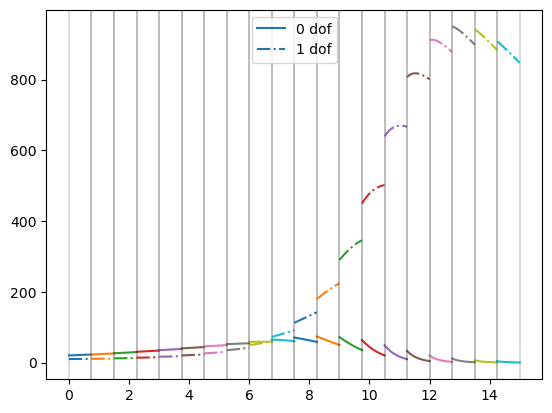

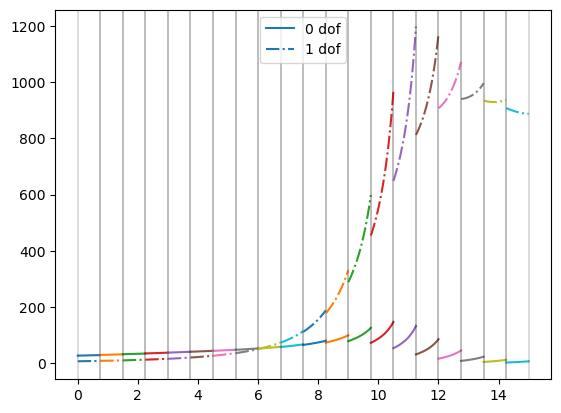

[27.0375, 6.95736, 29.5059, 8.41583, 32.1057, 10.2217, 34.8307, 12.583, 37.6882, 15.7612, 40.709, 20.1699, 43.974, 26.4844, 47.6581, 35.8457, 52.0906, 50.2544, 57.7804, 73.3447, 65.1752, 111.851, 73.5562, 177.791, 78.6949, 288.536, 72.7737, 454.229, 53.573, 648.902, 31.464, 812.494, 16.2971, 907.344, 8.38096, 940.437, 4.55492, 934.654, 2.64443, 908.119, 0.0790637, 0.0107293, -0.00132581, 0.0780327]
min: 870.101

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[44],p[],lbx[44],ubx[44],lbg[38],ubg[38],lam_x0[44],lam_g0[38])->(x[44],f,g[38],lam_x[44],lam_g[38],

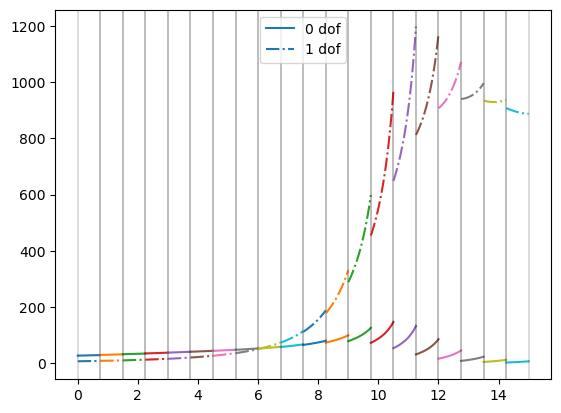

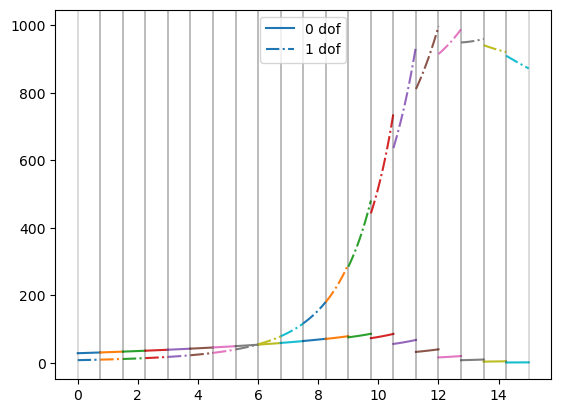

[28.9787, 8.43983, 31.2453, 9.93472, 33.7052, 11.8973, 36.3817, 14.5152, 39.3028, 18.0709, 42.5051, 23.0005, 46.0386, 29.9946, 49.9723, 40.1808, 54.4015, 55.4644, 59.4432, 79.1807, 65.1718, 117.321, 71.2989, 180.488, 76.0046, 284.796, 73.46, 442.573, 56.4749, 636.205, 32.8467, 810.814, 16.5348, 914.407, 8.24818, 948.725, 4.12031, 940.716, 1.55537, 909.534, 0.097647, 0.00953495, -0.000200321, 0.0730514]
min: 748.669

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[44],p[],lbx[44],ubx[44],lbg[38],ubg[38],lam_x0[44],lam_g0[38])->(x[44],f,g[38],lam_x[44],lam_g[

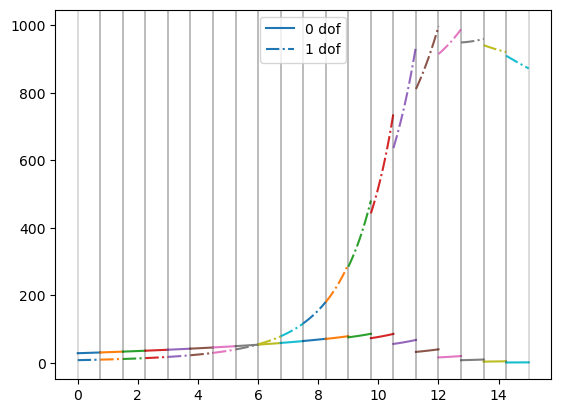

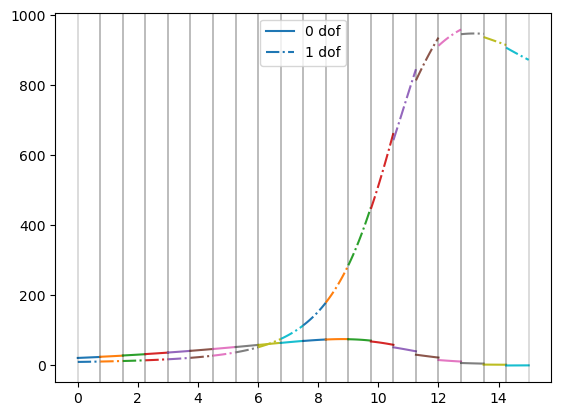

[20.3938, 8.98541, 23.6966, 10.0906, 27.3559, 11.5843, 31.3953, 13.6414, 35.8335, 16.5365, 40.6802, 20.7111, 45.9282, 26.8901, 51.5385, 36.2915, 57.413, 51.0019, 63.338, 74.6523, 68.8634, 113.577, 73.0339, 178.482, 73.8249, 285.121, 67.4777, 446.247, 50.7335, 642.816, 29.6152, 813.635, 14.3595, 912.737, 5.91711, 945.704, 1.38397, 937.612, -1.17528, 907.322, 0.179365, 0.00905537, 0.000698383, 0.0432798]
min: 359.605

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[44],p[],lbx[44],ubx[44],lbg[38],ubg[38],lam_x0[44],lam_g0[38])->(x[44],f,g[38],lam_x[44],lam_g[

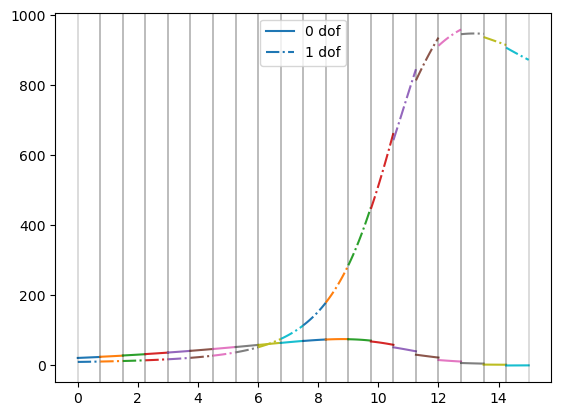

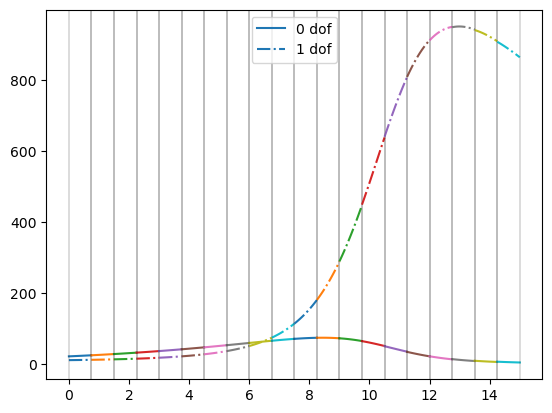

[20.7625, 10.1092, 23.8099, 11.0442, 27.2847, 12.3616, 31.232, 14.2245, 35.6927, 16.8914, 40.6943, 20.7849, 46.2351, 26.6147, 52.2539, 35.6077, 58.5735, 49.9328, 64.7975, 73.4654, 70.1367, 113.027, 73.1709, 179.801, 71.7459, 288.654, 63.7135, 448.603, 49.3933, 640.037, 33.4477, 808.97, 20.9543, 912.118, 12.9996, 949.093, 8.35646, 941.192, 5.72368, 908.143, 0.192582, 0.0101733, 0.000950412, 0.111871]
min: 30.3573

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[44],p[],lbx[44],ubx[44],lbg[38],ubg[38],lam_x0[44],lam_g0[38])->(x[44],f,g[38],lam_x[44],lam_g[38]

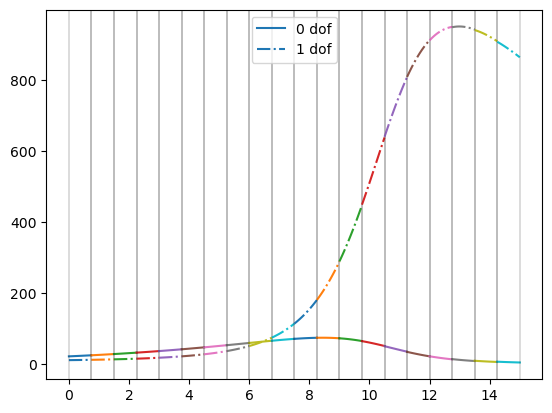

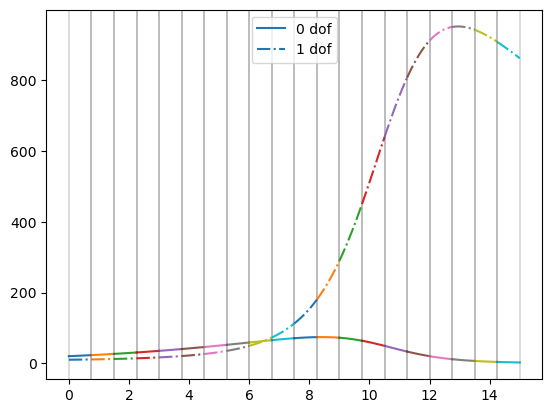

[19.9684, 9.98871, 23.0273, 10.8897, 26.5323, 12.1669, 30.5348, 13.9809, 35.0824, 16.5874, 40.2101, 20.4058, 45.9234, 26.1438, 52.1649, 35.0318, 58.7515, 49.2612, 65.2585, 72.7805, 70.823, 112.584, 73.8931, 180.095, 72.1981, 290.009, 63.7383, 449.885, 49.2254, 639.228, 33.1201, 807.12, 20.0798, 911.929, 11.533, 950.419, 6.54052, 942.354, 3.75619, 908.199, 0.200201, 0.00998128, 0.0010012, 0.0989388]
min: 0.0369296

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[44],p[],lbx[44],ubx[44],lbg[38],ubg[38],lam_x0[44],lam_g0[38])->(x[44],f,g[38],lam_x[44],lam_g[38

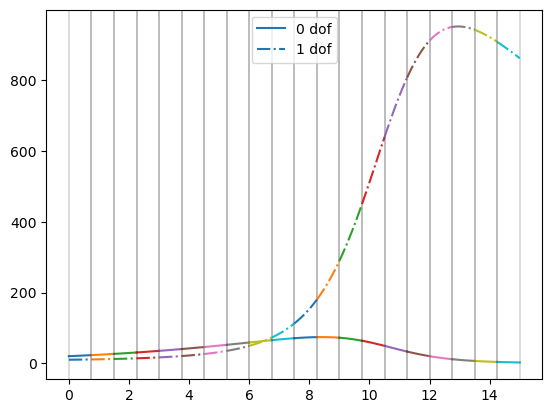

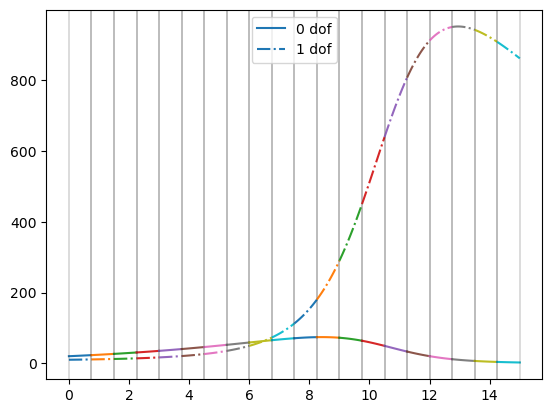

[20, 9.99998, 23.0557, 10.9002, 26.5569, 12.1769, 30.5547, 13.9907, 35.0968, 16.5973, 40.2184, 20.4158, 45.925, 26.1539, 52.1598, 35.0415, 58.7403, 49.2691, 65.2425, 72.7841, 70.8041, 112.579, 73.8729, 180.082, 72.1789, 289.989, 63.7279, 449.869, 49.238, 639.237, 33.1559, 807.164, 20.1271, 911.948, 11.589, 950.387, 6.60674, 942.305, 3.83064, 908.185, 0.2, 0.00999997, 0.001, 0.0999982]
min: 2.80778e-08
Solution found!


In [33]:
#ParametricEstimation(DefineOneShootingNodForDAE_LV, GroundTruth, GroundTruth_perturb, OptSolver.qp)

ParametricEstimation(DefineOneShootingNodForDAE_LV, GroundTruth, GroundTruth_perturb, OptSolver.qp,
                         CasADi_norm=norm_2, t0=0, tf=15, NumberShootingNodes=20, TrueSolutionMeasurements=None)


S:(x0[34],p[],lbx[34],ubx[34],lbg[28],ubg[28],lam_x0[34],lam_g0[28])->(x[34],f,g[28],lam_x[34],lam_g[28],lam_p[]) IpoptInterface
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      196
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      595

Total number of variables............................:       34
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr  

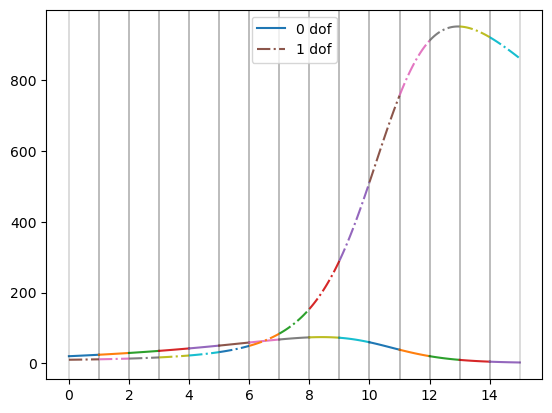

{'Sn': DM(
[[20.4025, 24.1708, 29.1638, 35.0968, 42.0566, 50.0305, 58.7402, 67.2609, 73.2565, 72.1792, 59.4106, 38.3544, 20.1272, 9.60421, 4.5804], 
 [10.2342, 11.2775, 13.3132, 16.5973, 22.0683, 31.6203, 49.269, 83.7762, 153.605, 289.987, 511.84, 756.883, 911.95, 951.734, 921.467]]), 'p': DM([0.199874, 0.00643692, 0.00354256, 0.102448])}


[20, 10, 24.1708, 11.2775, 29.1638, 13.3132, 35.0968, 16.5973, 42.0566, 22.0683, 50.0305, 31.6203, 58.7402, 49.269, 67.2609, 83.7762, 73.2565, 153.605, 72.1792, 289.987, 59.4106, 511.84, 38.3544, 756.883, 20.1272, 911.95, 9.60421, 951.734, 4.5804, 921.467, 0.2, 0.01, 0.001, 0.1]
{'Sn': DM([20, 10]), 'p': DM([0.2, 0.01, 0.001, 0.1])}
min: 3.73492e-19




In [34]:
# ParametricEstimation(DefineOneShootingNodForDAE_LV, GroundTruth, GroundTruth_perturb, OptSolver.nlp)

ParametricEstimation(DefineOneShootingNodForDAE_LV, GroundTruth, GroundTruth_perturb, OptSolver.nlp,
                         CasADi_norm=norm_2, t0=0, tf=15, NumberShootingNodes=15, TrueSolutionMeasurements=None)


In [35]:
def Notorious(t0, tf, NrEvaluationPoints = 40):
    x0 = SX.sym('x0')
    x1 = SX.sym('x1')
    x = vertcat(x0, x1)
    # mu = SX.sym('mu')
    mu = 60
    p = SX.sym('p')
    t = SX.sym('t')
    xdot = vertcat(x1, mu * mu * x0 - (mu * mu + p * p) * sin(p * t))
    ode = {'x': x, 't': t, 'p': p, 'ode': xdot}

    time = np.insert(np.linspace(t0, tf, NrEvaluationPoints), t0, 0)
    I_plot = integrator('I_plot', 'cvodes', ode, {'grid': time});
    I = integrator('I', 'cvodes', ode, {'t0': t0, 'tf': tf})

    return I, 2, 1, I_plot


In [36]:
GroundTruthNotorious = {
    'Sn': DM([0, pi]),
    'p': DM([pi])
}


In [37]:
GroundTruthNotorious_perturb = {
    'Sn': GroundTruthNotorious['Sn'] + 0.1 * np.random.normal(0, 0.4, GroundTruthNotorious['Sn'].shape),
    'p': GroundTruthNotorious['p'] + 0.1 * np.random.normal(0, 0.2, GroundTruthNotorious['p'].shape)
}


In [38]:
readings = 10
times = np.linspace(0, 1, readings+1, True)[1:]
t = MX.sym('t')
x0 = Function('x0', [t], [sin(pi * t)], ['t'], ['out'])
x1 = Function('x1', [t], [pi * cos(pi * t)], ['t'], ['out'])
x = Function('x', [t], [vertcat(x0(t), x1(t))], ['t'], ['out'])
x_map = x.map(readings)
TrueSolutionMeasurements = x_map(times)



qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[21],p[],lbx[21],ubx[21],lbg[18],ubg[18],lam_x0[21],lam_g0[18])->(x[21],f,g[18],lam_x[21],lam_g[18],lam_p[]) MXFunction

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR

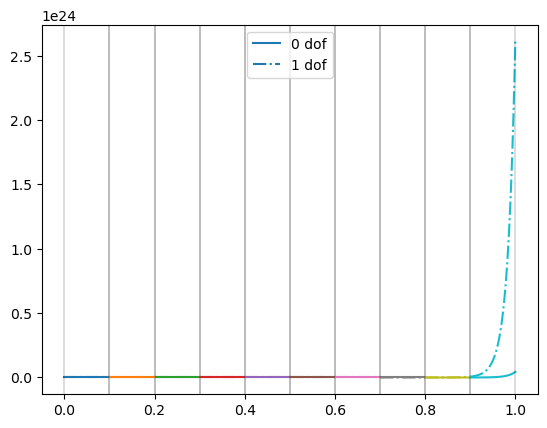

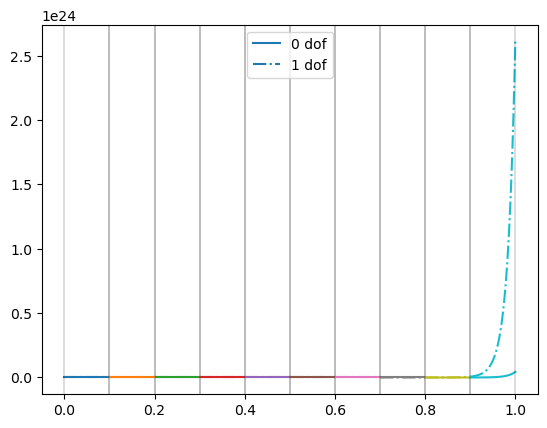

[1.73149, -100.879, 0.306848, 2.9872, 62.1207, 3712.29, 25001.7, 1.50008e+06, 1.00865e+07, 6.05191e+08, 4.06927e+09, 2.44156e+11, 1.64169e+12, 9.85015e+13, 6.62318e+14, 3.97391e+16, 2.67203e+17, 1.60322e+19, 1.078e+20, 6.46797e+21, 3.00881]
min: 7.95449

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[21],p[],lbx[21],ubx[21],lbg[18],ubg[18],lam_x0[21],lam_g0[18])->(x[21],f,g[18],lam_x[21],lam_g[18],lam_p[]) MXFunction

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian

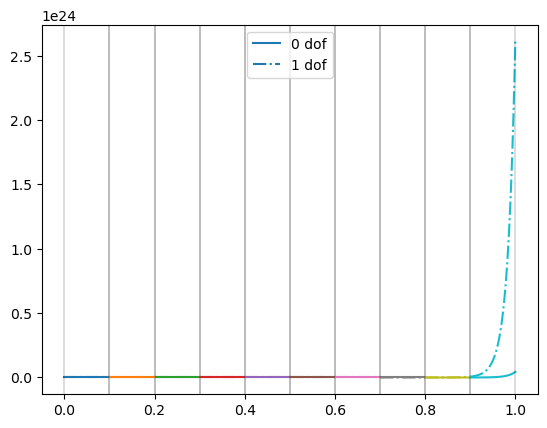

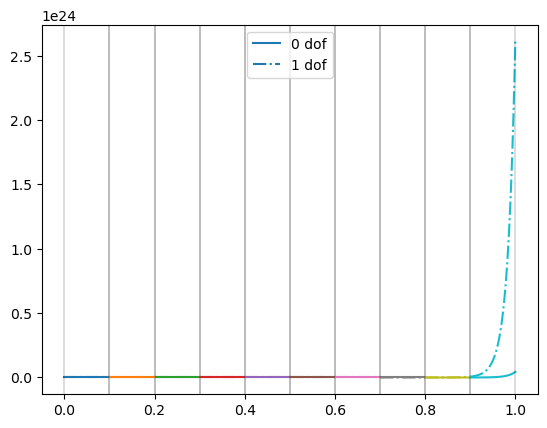

[4.1596, -246.748, 0.303813, 2.98628, 62.1116, 3712.65, 25001.6, 1.50008e+06, 1.00865e+07, 6.05191e+08, 4.06927e+09, 2.44156e+11, 1.64169e+12, 9.85015e+13, 6.62318e+14, 3.97391e+16, 2.67203e+17, 1.60322e+19, 1.078e+20, 6.46797e+21, 2.82321]
min: 22.4967

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[21],p[],lbx[21],ubx[21],lbg[18],ubg[18],lam_x0[21],lam_g0[18])->(x[21],f,g[18],lam_x[21],lam_g[18],lam_p[]) MXFunction

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian

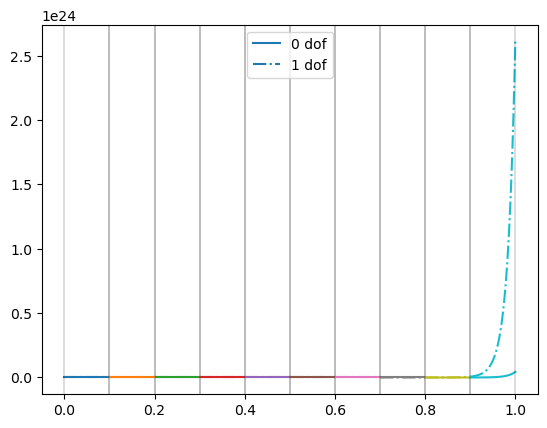

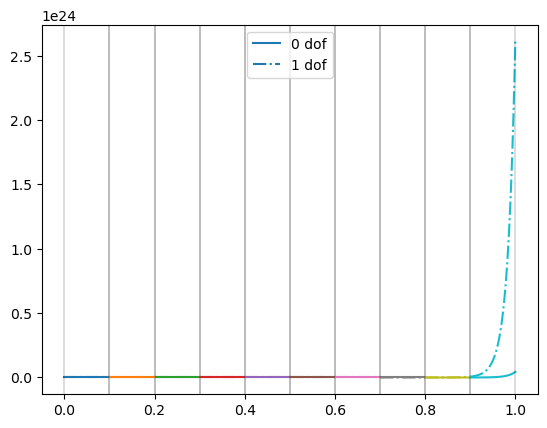

[-1000.6, 60114.5, 1.55499, 3.37761, 65.8565, 3563.42, 25005.4, 1.49994e+06, 1.00865e+07, 6.05191e+08, 4.06927e+09, 2.44156e+11, 1.64169e+12, 9.85015e+13, 6.62318e+14, 3.97391e+16, 2.67203e+17, 1.60322e+19, 1.078e+20, 6.46797e+21, 79.3585]
min: 2.30286e+06

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[21],p[],lbx[21],ubx[21],lbg[18],ubg[18],lam_x0[21],lam_g0[18])->(x[21],f,g[18],lam_x[21],lam_g[18],lam_p[]) MXFunction

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christ

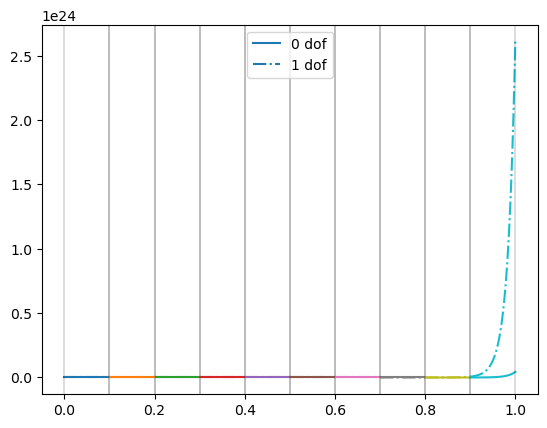

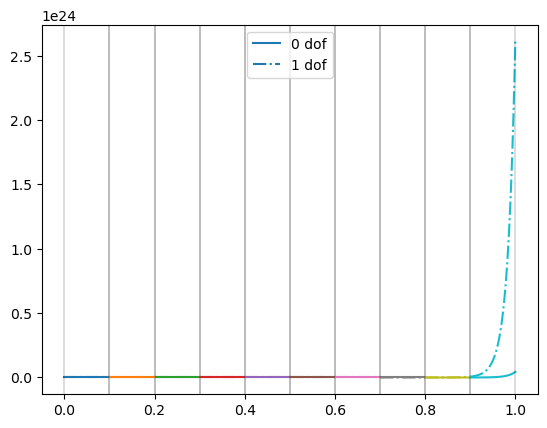

[-481103, 2.88888e+07, 374.755, 177.496, 1630.04, -67722.8, 26572.5, 1.42847e+06, 1.00881e+07, 6.05119e+08, 4.06927e+09, 2.44156e+11, 1.64169e+12, 9.85015e+13, 6.62318e+14, 3.97391e+16, 2.67203e+17, 1.60322e+19, 1.078e+20, 6.46797e+21, 22124.9]
min: 2.07268e+11

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[21],p[],lbx[21],ubx[21],lbg[18],ubg[18],lam_x0[21],lam_g0[18])->(x[21],f,g[18],lam_x[21],lam_g[18],lam_p[]) MXFunction


At t = 0.0528828, mxstep steps taken before reaching tout.
Function I (0x249a8650)
Input 0 (x0): [374.755, 177.496]
Input 1 (z0): 0x1
Input 2 (p): 22124.9
Input 3 (u): 0x1
Input 4 (adj_xf): 0x0
Input 5 (adj_zf): 0x0
Input 6 (adj_qf): 0x0
Function map10_I (0x15ee4530)
Input 0 (x0): 
[[-481103, 374.755, 1630.04, 26572.5, 1.00881e+07, 4.06927e+09, 1.64169e+12, 6.62318e+14, 2.67203e+17, 1.078e+20], 
 [2.88888e+07, 177.496, -67722.8, 1.42847e+06, 6.05119e+08, 2.44156e+11, 9.85015e+13, 3.97391e+16, 1.60322e+19, 6.46797e+21]]
Input 1 (z0): 0x10
Input 2 (p): [[22124.9, 22124.9, 22124.9, 22124.9, 22124.9, 22124.9, 22124.9, 22124.9, 22124.9, 22124.9]]
Input 3 (u): 0x10
Input 4 (adj_xf): 0x0
Input 5 (adj_zf): 0x0
Input 6 (adj_qf): 0x0
Function fwd21_adj1_eval_norm_GGN_exp (0x1013a2b0)
Input 0 (x0_perturb): 
[[-481103, 374.755, 1630.04, 26572.5, 1.00881e+07, 4.06927e+09, 1.64169e+12, 6.62318e+14, 2.67203e+17, 1.078e+20], 
 [2.88888e+07, 177.496, -67722.8, 1.42847e+06, 6.05119e+08, 2.44156e+11, 9.8

RuntimeError: Error in Function::call for 'S' [MXFunction] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'S' [MXFunction] at .../casadi/core/function.cpp:361:
Error in Function::operator() for 'S_qp' [MXFunction] at .../casadi/core/function.cpp:1513:
Error in Function::operator() for 'fwd21_adj1_eval_norm_GGN_exp' [MXFunction] at .../casadi/core/function.cpp:1513:
Error in Function::operator() for 'map10_I' [Map] at .../casadi/core/function.cpp:1513:
Error in Function::operator() for 'I' [CvodesInterface] at .../casadi/core/function.cpp:1513:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.

In [39]:
ParametricEstimation(Notorious, GroundTruthNotorious, GroundTruthNotorious_perturb, OptSolver.qp,
                     norm_2, t0=0, tf=1, NumberShootingNodes=readings)

S:(x0[21],p[],lbx[21],ubx[21],lbg[18],ubg[18],lam_x0[21],lam_g0[18])->(x[21],f,g[18],lam_x[21],lam_g[18],lam_p[]) IpoptInterface
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       72
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      231

Total number of variables............................:       21
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       18
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr  

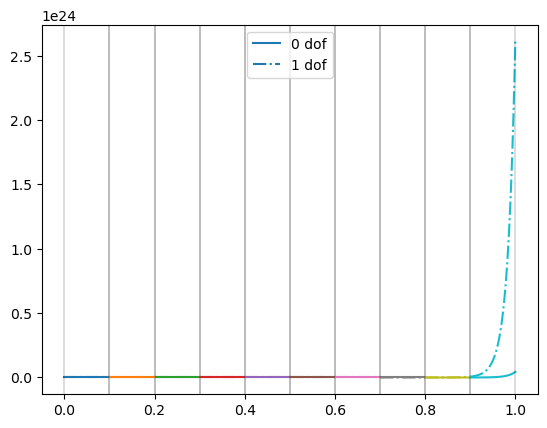

{'Sn': DM(
[[-0.00148811, 0.309018, 62.1272, 25001.7, 1.00865e+07, 4.06927e+09, 1.64169e+12, 6.62318e+14, 2.67203e+17, 1.078e+20], 
 [3.06422, 2.98791, 3712.03, 1.50008e+06, 6.05191e+08, 2.44156e+11, 9.85015e+13, 3.97391e+16, 1.60322e+19, 6.46797e+21]]), 'p': DM(3.11964)}


[-0.00148811, 3.06422, 0.309018, 2.98791, 62.1272, 3712.03, 25001.7, 1.50008e+06, 1.00865e+07, 6.05191e+08, 4.06927e+09, 2.44156e+11, 1.64169e+12, 9.85015e+13, 6.62318e+14, 3.97391e+16, 2.67203e+17, 1.60322e+19, 1.078e+20, 6.46797e+21, 3.11964]
{'Sn': DM([20, 10]), 'p': DM([0.2, 0.01, 0.001, 0.1])}
min: 108560




In [40]:
ParametricEstimation(Notorious, GroundTruthNotorious, GroundTruthNotorious_perturb, OptSolver.nlp,
                     norm_2, t0=0, tf=1, NumberShootingNodes=readings)

In [41]:
def Pyridine(t0, tf, NrEvaluationPoints = 40):
    A = SX.sym('A')
    B = SX.sym('B')
    C = SX.sym('C')
    D = SX.sym('D')
    E = SX.sym('E')
    F = SX.sym('F')
    G = SX.sym('G')
    x = vertcat(A, B, C, D, E, F, G)
    # p = SX.sym('p',11)
    p1 = SX.sym('p1');
    p2 = SX.sym('p2');
    p3 = SX.sym('p3');
    p4 = SX.sym('p4');
    p5 = SX.sym('p5');
    p6 = SX.sym('p6');
    p7 = SX.sym('p7');
    p8 = SX.sym('p8');
    p9 = SX.sym('p9');
    p10 = SX.sym('p10');
    p11 = SX.sym('p11');
    p = vertcat(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11);
    xdot = vertcat(-p1 * A + p9 * B,
                   p1 * A - p2 * B - p3 * B * C - p7 * D - p9 * B + p10 * D * F,
                   p2 * B - p3 * B * C - 2 * p4 * C * C - p6 * C + p8 * E + p10 * D * F + 2 * p11 * E * F,
                   p3 * B * C - p5 * D - p7 * D - p10 * D * F,
                   p4 * C * C + p5 * D - p8 * E - p11 * E * F,
                   p3 * B * C + p4 * C * C + p6 * C - p10 * D * F - p11 * E * F,
                   p6 * C + p7 * D + p8 * F)
    ode = {'x': x, 'p': p, 'ode': xdot}
    time = np.insert(np.linspace(t0, tf, NrEvaluationPoints), t0, 0)
    I_plot = integrator('I_plot', 'cvodes', ode, {'grid': time});
    I = integrator('I', 'cvodes', ode, {'t0': t0, 'tf': tf})

    return I, 7, 11, I_plot


In [42]:
GroundTruthPyridine= {
    'Sn': DM([1, 0, 0, 0, 0, 0, 0]),
    'p': DM([1.81, 0.894, 29.4, 9.21, 0.0580, 2.43, 0.0644, 5.55, 0.0201, 0.577, 2.15])/4.5
}


In [43]:
# GroundTruthPyridine_perturb = {
#     'Sn': GroundTruthPyridine['Sn'] + 0.1 * np.random.normal(0, 0.4, GroundTruthPyridine['Sn'].shape),
#     'p': GroundTruthPyridine['p'] + 0.1 * np.random.normal(0, 0.4, GroundTruthPyridine['p'].shape)
# }

GroundTruthPyridine_perturb = {
    'Sn': GroundTruthPyridine['Sn'] + 0.2 * np.random.normal(0, 0.8, GroundTruthPyridine['Sn'].shape),
    'p': GroundTruthPyridine['p'] + 0.2 * np.random.normal(0, 0.8, GroundTruthPyridine['p'].shape)
}



S:(x0[67],p[],lbx[67],ubx[67],lbg[49],ubg[49],lam_x0[67],lam_g0[49])->(x[67],f,g[49],lam_x[67],lam_g[49],lam_p[]) IpoptInterface
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      889
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2278

Total number of variables............................:       67
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr  

Internal t = 0.0294136 and h = 1.36683e-18 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 0.0294136 and h = 1.36683e-18 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 0.0294136 and h = 1.36683e-18 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 0.0294136 and h = 1.36683e-18 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 0.0294136 and h = 1.36683e-18 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 0.0294136 and h = 1.36683e-18 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 0.0294136 and h = 9.80964e-19 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 0.0294136 and h = 9.80964e-19 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 0.0294136 and h = 9.80964e-19 are such that

   1  4.0564924e-01 3.81e-01 4.07e-01  -1.7 6.82e+01  -2.0 1.00e+00 7.81e-03h  8
   2  4.7249468e-02 1.28e-01 3.84e-01  -1.7 7.63e-01  -1.6 1.00e+00 1.00e+00h  1
   3  1.2553091e-02 1.06e-02 6.84e-02  -1.7 1.36e-01  -0.2 1.00e+00 1.00e+00h  1
   4  3.8996788e-03 3.05e-03 1.45e-02  -2.5 7.22e-02  -0.7 1.00e+00 1.00e+00h  1
   5  1.7811158e-03 1.17e-03 7.94e-03  -3.8 5.74e-02  -1.2 1.00e+00 1.00e+00h  1
   6  1.2414084e-03 2.33e-03 6.33e-03  -3.8 1.15e-01  -1.7 1.00e+00 1.00e+00h  1
   7  6.5598889e-04 1.88e-03 4.29e-03  -3.8 2.65e-01  -2.2 1.00e+00 1.00e+00h  1
   8  9.6330350e-05 8.84e-04 2.47e-03  -3.8 4.17e-01  -2.6 1.00e+00 1.00e+00h  1
   9  3.2899605e-06 3.11e-04 8.00e-04  -3.8 1.52e-01  -3.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2064501e-08 1.68e-05 6.32e-05  -5.7 6.17e-01    -  1.00e+00 1.00e+00h  1
  11  2.6641157e-12 1.44e-07 4.31e-07  -5.7 1.33e-01    -  1.00e+00 1.00e+00h  1
  12  1.0193625e-17 7.66e-10

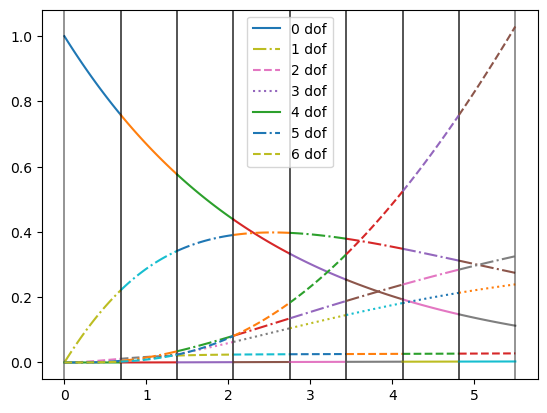

{'Sn': DM(
[[1.1091, 0.758748, 0.576227, 0.438016, 0.333261, 0.253794, 0.193457, 0.147604], 
 [-0.0286214, 0.221501, 0.341867, 0.390797, 0.397192, 0.379276, 0.348484, 0.312088], 
 [-0.191029, 0.0112542, 0.0212056, 0.0242263, 0.0252329, 0.0258586, 0.0264548, 0.0271083], 
 [0.422392, 0.00336546, 0.0256699, 0.0630475, 0.104838, 0.145416, 0.182063, 0.213508], 
 [-0.0639232, 4.44722e-05, 0.000408495, 0.000954026, 0.00148192, 0.00195743, 0.00237891, 0.00274631], 
 [-0.040515, 0.0050726, 0.0343569, 0.0818356, 0.13522, 0.188457, 0.238692, 0.284572], 
 [-0.163121, 0.00268643, 0.0240261, 0.0815095, 0.183419, 0.331502, 0.524194, 0.758261]]), 'p': DM([0.224039, 0.194051, 6.35695, 1.81756, -0.153254, 0.296123, -0.00933684, 1.12611, 0.148336, 0.288017, 0.457868])}


[1, 8.40752e-11, -1.31781e-09, 1.79104e-09, -1.72383e-09, 1.94735e-09, -3.87232e-10, 0.758748, 0.221501, 0.0112542, 0.00336546, 4.44715e-05, 0.0050726, 0.00268643, 0.576227, 0.341867, 0.0212056, 0.0256699, 0.000408495, 0.0343569, 0.02402

In [44]:
ParametricEstimation(Pyridine,GroundTruthPyridine,GroundTruthPyridine_perturb,OptSolver.nlp,
                     norm_2,t0=0, tf=5.5)


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

S:(x0[67],p[],lbx[67],ubx[67],lbg[49],ubg[49],lam_x0[67],lam_g0[49])->(x[67],f,g[49],lam_x[67],lam_g[49],lam_p[]) MXFunction

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR

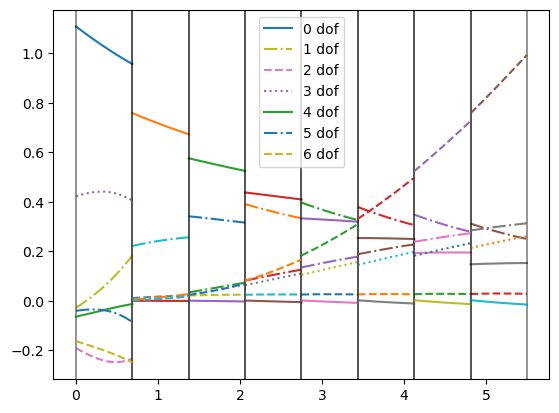

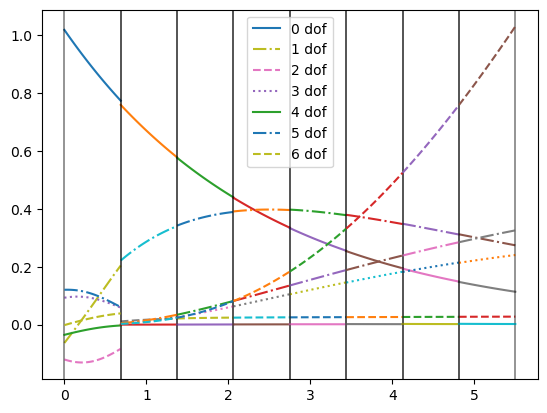

[1.01776, -0.063248, -0.120178, 0.0929696, -0.0352124, 0.120444, -0.0016142, 0.758773, 0.221406, 0.011224, 0.0034128, 0.000102824, 0.0049589, 0.00266274, 0.576146, 0.342008, 0.0212797, 0.0257037, 0.000297093, 0.0342388, 0.0239226, 0.437994, 0.390849, 0.0241926, 0.0631192, 0.000814112, 0.0818883, 0.0814767, 0.333332, 0.397194, 0.0251982, 0.10481, 0.00141563, 0.135282, 0.183478, 0.253917, 0.379239, 0.0258535, 0.145295, 0.00199108, 0.188479, 0.331599, 0.193555, 0.348426, 0.0264722, 0.181931, 0.00248254, 0.23868, 0.524269, 0.147587, 0.31205, 0.02713, 0.213473, 0.00286564, 0.284537, 0.758272, 0.400492, 0.200496, 6.49186, 1.94169, 0.00316227, 0.55901, 0.013226, 1.23185, 0.00890656, 0.13158, 0.140498]
min: 3.5136e-07
Solution found!


In [45]:
ParametricEstimation(Pyridine,GroundTruthPyridine,GroundTruthPyridine_perturb,OptSolver.qp,
                     norm_2,t0=0, tf=5.5)